In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#default_exp tree.cart
from nbdev.showdoc import show_doc

The implementation is borrowed from cornel cs4780 course project

<h3>Introduction</h3>
<p>In this assignment you will implement a decision tree algorithm and then use it for bagging and boosting. We've provided a tree structure for you with distinct leaves and nodes. Leaves have two fields, parent (another node) and prediction (a numerical value). Nodes have six fields: 

<ol>
<li> <b>left</b>: node describing left subtree </li>
<li> <b>right</b>: node describing right subtree </li>
<li> <b>parent</b>: the parent of the current subtree. The head of the tree always has <code><b>None</b></code> as its parent. Feel free to initialize nodes with this field set to <code><b>None</b></code> so long as you set the correct parent later on. </li>
<li> <b>cutoff_id</b>: index of feature to cut </li>
<li> <b>cutoff_val</b>: cutoff value c (<=c : left, and >c : right)</li>
<li> <b>prediction</b>: prediction at this node </li>
</ol>
</p>

In [3]:
#export

class TreeNode(object):
    """Tree class.
    """
    
    def __init__(self, left, right, parent, cutoff_id, cutoff_val, prediction):
        self.left = left
        self.right = right
        self.parent = parent
        self.cutoff_id = cutoff_id
        self.cutoff_val = cutoff_val
        self.prediction = prediction
        
        

In [4]:
from scipy.io import loadmat

# load in some binary test data (labels are -1, +1)
data = loadmat("ion.mat")
xTrIon  = data['xTr'].T
yTrIon  = data['yTr'].flatten()
xTeIon  = data['xTe'].T
yTeIon  = data['yTe'].flatten()

xTrIon.shape, yTrIon.shape, xTeIon.shape, yTeIon.shape

((281, 34), (281,), (70, 34), (70,))

In [5]:
import numpy as np


def spiraldata(N=300):
    r = np.linspace(1,2*np.pi,N)
    xTr1 = np.array([np.sin(2.*r)*r, np.cos(2*r)*r]).T
    xTr2 = np.array([np.sin(2.*r+np.pi)*r, np.cos(2*r+np.pi)*r]).T
    xTr = np.concatenate([xTr1, xTr2], axis=0)
    yTr = np.concatenate([np.ones(N), -1 * np.ones(N)])
    xTr = xTr + np.random.randn(xTr.shape[0], xTr.shape[1])*0.2
    
    xTe = xTr[::2,:]
    yTe = yTr[::2]
    xTr = xTr[1::2,:]
    yTr = yTr[1::2]
    
    return xTr,yTr,xTe,yTe

xTrSpiral,yTrSpiral,xTeSpiral,yTeSpiral=spiraldata(150)

<h3> Efficiently implementing regression trees </h3>
<p>First, implement the function <code>sqsplit</code> which takes as input a (weighted) data set with labels and computes the best feature and cut-value of an optimal split based on minimum squared error. The third input is a weight vector which assigns a positive weight to each training sample. The loss you should minimize is the averaged weighted squared-loss:
$$
	{\cal L}(S)=\sum_{i \in L} {w_{i}(y_{i} - T_{L})}^2+\sum_{i \in R} {w_{i}(y_{i} - T_{R})}^2.\label{q2:loss}
$$
<br>
</p>

You are building a regression tree, and right now you need to choose a split for the given dataset $S=\{(\vec x_1,y_1),\dots,(\vec x_n,y_n)\}$ (where we have continuous labels $y_i\in{\cal R}$).
Suppose you split on some feature $j$ with value $c$ and partition the dataset in to two sets of indices, $L$--the set of indices on the left (i.e., $i \in L \Rightarrow [x_{i}]_{j} < c$)--and $R$--the set of indices on the right (i.e., $i \in R \Rightarrow [x_{i}]_{j} > c$). Suppose you assign every data point on the left the prediction $T_{L}$ and every data point on the right the prediction $T_{R}$. Finally, suppose that each data point $x_{i}$ has an associated weight $w_{i}$, and that the weights are normalized (i.e., $\sum_{i} w_{i} = 1$). 


<p> First, we show that setting $T_{L}$ and $T_{R}$ to the weighted average label over their respective sets (i.e., $T_{L} = \frac{1}{W_{L}}\sum_{i\in L}w_{i}y_{i}$ and $T_{R} = \frac{1}{W_{R}}\sum_{i\in R}w_{i}y_{i}$) minimizes the loss $\cal L$, where $W_{L}=\sum_{i \in L}w_{i}$ and $W_{R}=\sum_{i \in R} w_{i}$ are the total weight of the left and right side respectively.

<p> We take the derivative of the loss with respect to $T_{L}$ to obtain $$\frac{d}{dT_{L}} {\cal L}(S) = -2\sum_{i \in L}w_{i}(y_i - T_L)=-2\sum_{i\in L}w_iy_i + 2T_{L}\sum_{i}w_{i}$$ Setting this equal to zero and solving, we get $$2T_{L}w_{L}=2\sum_{i \in L}w_{i}y_{i}$$ and therefore $$T_{L} = \frac{1}{W_{L}}\sum_{i \in L}w_{i}y_{i}$$ A symmetric argument holds for $T_{R}$.</p>

<p> Now, imagine you are considering splitting on some feature $j$, and suppose you have already sorted the training points in the order of this feature value, so that $[x_{1}]_{j} < [x_{2}]_{j} < \cdots < [x_{n}]_{j}$. You'd like to choose a split from among $c_{1} \leq c_{2} \leq \cdots \leq c_{n-1}$, where $c_{i}=\frac{[x_{i}]_{j}+[x_{i+1}]_{j}}{2}$. One way to do this would be to, for each possible split $c_{k}$, decide whether each $x_{i}$ should be partitioned left or right, and compute $\cal L$. At the end, take the split with the lowest loss. The number of data points $n$ and there are $O(n)$ splits to consider, and the proposed algorithm would require $O(n)$ per split to evaluate $\cal L$, for a total of $O(n^2)$ time.

<p> Now, suppose some split $c_{k}$ results in the data being partitioned in to $L^{(k)}$ and $R^{(k)}$. Suppose you are given the following quantities precomputed: $W_{L^{(k)}}$, $P_{L^{(k)}} = \sum_{i \in L} w_{i}y_{i}$, and $Q_{L^{(k)}} = \sum_{i \in L} w_{i}y_{i}^{2}$. Similarly, you are given $W_{R^{(k)}}$, $P_{R^{(k)}}$ and $Q_{R^{(k)}}$ Equipped with these precomputed quantities, we can compute $\cal L$ in constant time:

<p>Expand the left side of the loss to $$\sum_{i \in L}w_{i}y_{i}^{2} - 2\sum_{i \in L}w_{i}y_{i}T_{L} + \sum_{i \in L}w_{i}T_{L}^{2}$$. The first term is exactly $Q_{L^{(k)}}$. The second term can be written as $-2P_{L^{(k)}}\frac{P_{L^{(k)}}}{W_{L^{(k)}}}=-2\frac{P_{L^{(k)}}^{2}}{w_{L^{(k)}}}$. The last term can be written as $w_{L^{(k)}}\frac{P_{L^{(k)}}^{2}}{w_{L^{(k)}}^{2}}=\frac{P_{L^{(k)}}^{2}}{w_{L^{(k)}}}$. The second term plus the third term is therefore simply $-\frac{P_{L^{(k)}}^{2}}{w_{L^{(k)}}}$. Therefore the whole expression can be evaluated as: $$Q_{L^{(k)}}-\frac{P_{L^{(k)}}^{2}}{w_{L^{(k)}}}$$ Similarly, the right term is: $$Q_{R^{(k)}}-\frac{P_{R^{(k)}}^{2}}{w_{R^{(k)}}}$$</p>

<p> <b> Efficent Update Rule: </b> If all feature values are distinct, only one data point moves from $R$ to $L$ when moving from split $k$ to split $k+1$. Therefore, we simply update the values accordingly. For example, we subtract $w_{k}$ from $W_{R^{(k)}}$ and add it to $W_{L^{(k)}}$. We subtract $w_{k}y_{k}$ from $P_{R^{(k)}}$ and add it to $P_{L^{(k)}}$. We subtract $w_{k}y_{k}^{2}$ from $Q_{R^{(k)}}$ and add it to $Q_{L^{(k)}}$. Crucially, all of these updates take only constant time. </p>

In [6]:
#export

def sqsplit_helper(xTr, yTr, weights, dim):
    """ Finds the best cut value and loss value for feature d
    
    Input:
        xTr:     n x d matrix of data points
        yTr:     n-dimensional vector of labels
        weights: n-dimensional weight vector for data points
        dim:     dimension to consider
    
    Output:
        cut:      cut-value of the best cut
        bestloss: loss of the best cut
    """
    N, _ = xTr.shape
    f, y, w = xTr[:,dim], yTr, weights
    ind = np.argsort(f)
    f, y, w = f[ind], y[ind], w[ind]
    
    cut = np.inf
    bestloss = np.inf
    
    WL = 0.0
    WR = 1.0
    PL = 0.0
    PR = np.inner(w, y)
    QL = 0.0
    QR = np.inner(w, y**2)
    
    for i in range(N-1):
        WL += w[i]
        WR -= w[i]
        PL += w[i] * y[i]
        PR -= w[i] * y[i]
        QL += w[i] * y[i]**2
        QR -= w[i] * y[i]**2
        leftL = QL - PL * PL / WL
        rightL = QR - PR * PR / WR
        loss = leftL + rightL
        if f[i] != f[i+1] and loss < bestloss:
            bestloss = loss
            cut = (f[i] + f[i+1]) / 2
            
    return cut, bestloss
    

def sqsplit(xTr,yTr,weights=None):
    """Finds the best feature, cut value, and loss value.
    
    Input:
        xTr:     n x d matrix of data points
        yTr:     n-dimensional vector of labels
        weights: n-dimensional weight vector for data points
    
    Output:
        feature:  index of the best cut's feature
        cut:      cut-value of the best cut
        bestloss: loss of the best cut
    """
    N,D = xTr.shape
    assert D > 0 # must have at least one dimension
    assert N > 1, xTr# must have at least two samples
    if weights is None: # if no weights are passed on, assign uniform weights
        weights = np.ones(N)
    weights = weights/sum(weights) # Weights need to sum to one (we just normalize them)
    bestloss = np.inf
    feature = np.inf
    cut = np.inf
    
    for dim in range(D):
        c, loss = sqsplit_helper(xTr, yTr, weights, dim)
        if loss < bestloss:
            cut = c
            bestloss = loss
            feature = dim
    
    return feature, cut, bestloss

In [7]:
%%time
fid,cut,loss = sqsplit(xTrIon,yTrIon)

print("It should split on feature 2 on value 0.29920161791103117")
print("Split on feature",fid,"on value:",cut)

It should split on feature 2 on value 0.29920161791103117
Split on feature 2 on value: 0.30440689508953356
CPU times: user 46.9 ms, sys: 15.6 ms, total: 62.5 ms
Wall time: 36.7 ms


<b>Cart tree:</b><p>Implement the function <code>cart</code> which returns a regression tree based on the minimum squared loss splitting rule. The function takes training data, test data, a maximum depth, and the weigh of each training example. Maximum depth and weight are optional arguments. If they are not provided you should make maximum depth infinity and equally weight each example. You should use the function <code>sqsplit</code> to make your splits.</p>

<p>Use the provided <code>TreeNode</code> class to represent your tree. Note that the nature of CART trees implies that every node has exactly 0 or 2 children.</p>

In [8]:
#export

def cart_helper(xTr, yTr, depth, weights, maxDepth):
    if xTr.shape[0] == 1:
        return TreeNode(None, None, None, None, None, yTr[0])

    w = weights / np.sum(weights)
    pred = np.dot(yTr, w)
    
    if depth == maxDepth or \
        np.var(yTr) == 0 or \
        np.sum(np.var(xTr, axis=0)) == 0:
        return TreeNode(None, None, None, None, None, pred) # leaf
    
    feature, cut, loss = sqsplit(xTr, yTr, weights)
    
    leftIdx = np.where(xTr[:,feature] <= cut)
    rightIdx = np.where(xTr[:,feature] > cut)
    
    if len(leftIdx[0]) == 0 or len(rightIdx[0]) == 0: # 
        return TreeNode(None, None, None, None, None, pred)

    leftR = cart_helper(xTr[leftIdx], yTr[leftIdx], depth+1, weights[leftIdx], maxDepth)
    rightR = cart_helper(xTr[rightIdx], yTr[rightIdx], depth+1, weights[rightIdx], maxDepth)
    
    root = TreeNode(leftR, rightR, None, feature, cut, pred)
    leftR.parent = root
    rightR.parent = root
    
    return root
    
    
def cart(xTr,yTr,maxdepth=np.inf,weights=None):
    """Builds a CART tree.
    
    The maximum tree depth is defined by "maxdepth" (maxdepth=2 means one split).
    Each example can be weighted with "weights".

    Args:
        xTr:      n x d matrix of data
        yTr:      n-dimensional vector
        maxdepth: maximum tree depth
        weights:  n-dimensional weight vector for data points

    Returns:
        tree: root of decision tree
    """
    n, _ = xTr.shape
    if weights is None:
        w = np.ones(n) / float(n)
    else:
        w = weights
    
    if n == 0:
        return None
    return cart_helper(xTr, yTr, 1, w, maxdepth)


In [9]:
#export


def eval_helper(root, point):
    if root.left is None and root.right is None: # is leaf
        return root.prediction
    
    dim = root.cutoff_id
    if point[dim] <= root.cutoff_val:
        return eval_helper(root.left, point)
    else:
        return eval_helper(root.right, point)

    
def eval_tree(root,xTe):
    """Evaluates xTe using decision tree root.
    
    Input:
        root: TreeNode decision tree
        xTe:  n x d matrix of data points
    
    Output:
        pred: n-dimensional vector of predictions
    """
    assert root is not None
    n = xTe.shape[0]
    pred = np.zeros(n)
    
    for i, x in enumerate(xTe):
        pred[i] = eval_helper(root, x)

    return pred

In [10]:
%%time

root = cart(xTrIon, yTrIon)
tr_err   = np.mean((eval_tree(root,xTrIon) - yTrIon)**2)
te_err   = np.mean((eval_tree(root,xTeIon) - yTeIon)**2)

print("Training RMSE : %.2f" % tr_err)
print("Testing  RMSE : %.2f" % te_err)

Training RMSE : 0.00
Testing  RMSE : 0.69
CPU times: user 156 ms, sys: 0 ns, total: 156 ms
Wall time: 164 ms


<p>The following code defines a function <code>visclassifier()</code>, which plots the decision boundary of a classifier in 2 dimensions. Execute the following code to see what the decision boundary of your tree looks like on the ion data set. </p>

In [11]:
#hide
import matplotlib.pyplot as plt
from numpy.matlib import repmat
%matplotlib notebook


def visclassifier(fun,xTr,yTr,w=None,b=0):
    """
    visualize decision boundary
    Define the symbols and colors we'll use in the plots later
    """

    yTr = np.array(yTr).flatten()
    
    symbols = ["ko","kx"]
    marker_symbols = ['o', 'x']
    mycolors = [[0.5, 0.5, 1], [1, 0.5, 0.5]]
    classvals = np.unique(yTr)

    plt.figure()

    res=300
    xrange = np.linspace(min(xTr[:, 0]), max(xTr[:, 0]),res)
    yrange = np.linspace(min(xTr[:, 1]), max(xTr[:, 1]),res)
    pixelX = repmat(xrange, res, 1)
    pixelY = repmat(yrange, res, 1).T

    xTe = np.array([pixelX.flatten(), pixelY.flatten()]).T

    testpreds = fun(xTe)
    Z = testpreds.reshape(res, res)
    # Z[0,0] = 1 # optional: scale the colors correctly
    plt.contourf(pixelX, pixelY, np.sign(Z), colors=mycolors)

    for idx, c in enumerate(classvals):
        plt.scatter(xTr[yTr == c,0],
            xTr[yTr == c,1],
            marker=marker_symbols[idx],
            color='k'
            )

    if w is not None:
        w = np.array(w).flatten()
        alpha = -1 * b / (w ** 2).sum()
        plt.quiver(w[0] * alpha, w[1] * alpha,
            w[0], w[1], linewidth=2, color=[0,1,0])

    plt.axis('tight')
    plt.show()
    

<IPython.core.display.Javascript object>


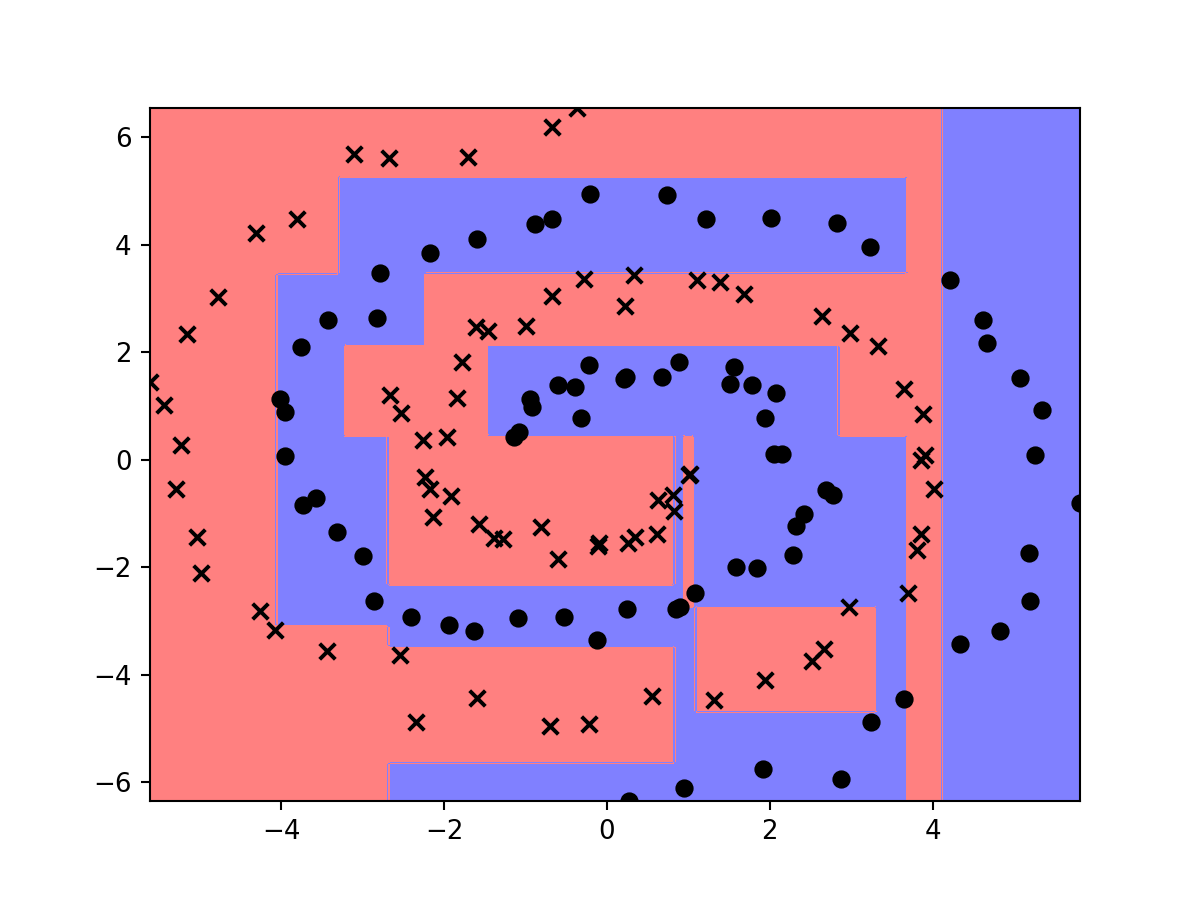

Training error: 0.0000
Testing error:  0.0667


In [12]:
#hide

tree=cart(xTrSpiral,yTrSpiral) # compute tree on training data 
visclassifier(lambda X:eval_tree(tree,X),xTrSpiral,yTrSpiral)
print("Training error: %.4f" % np.mean(np.sign(eval_tree(tree,xTrSpiral)) != yTrSpiral))
print("Testing error:  %.4f" % np.mean(np.sign(eval_tree(tree,xTeSpiral)) != yTeSpiral))

In [13]:
#hide
def onclick_cart(event):
    """
    Visualize cart, including new point
    """
    global xTraining,labels
    # create position vector for new point
    pos=np.array([[event.xdata,event.ydata]]) 
    if event.key == 'shift': # add positive point
        color='or'
        label=1
    else: # add negative point
        color='ob'
        label=-1    
    xTraining = np.concatenate((xTraining,pos), axis = 0)
    labels.append(label);
    marker_symbols = ['o', 'x']
    classvals = np.unique(labels)
        
    mycolors = [[0.5, 0.5, 1], [1, 0.5, 0.5]]
    
    # return 300 evenly spaced numbers over this interval
    res=300
    xrange = np.linspace(0, 1,res)
    yrange = np.linspace(0, 1,res)
    
    # repeat this matrix 300 times for both axes
    pixelX = repmat(xrange, res, 1)
    pixelY = repmat(yrange, res, 1).T

    xTe = np.array([pixelX.flatten(), pixelY.flatten()]).T

    # get decision tree
    tree=cart(xTraining,np.array(labels).flatten())
    fun = lambda X:eval_tree(tree,X)
    # test all of these points on the grid
    testpreds = fun(xTe)
    
    # reshape it back together to make our grid
    Z = testpreds.reshape(res, res)
    # Z[0,0] = 1 # optional: scale the colors correctly
    
    plt.cla()    
    plt.xlim((0,1))
    plt.ylim((0,1))
    # fill in the contours for these predictions
    plt.contourf(pixelX, pixelY, np.sign(Z), colors=mycolors)
    
    for idx, c in enumerate(classvals):
        plt.scatter(xTraining[labels == c,0],
            xTraining[labels == c,1],
            marker=marker_symbols[idx],
            color='k'
            )
    plt.show()
    

<IPython.core.display.Javascript object>


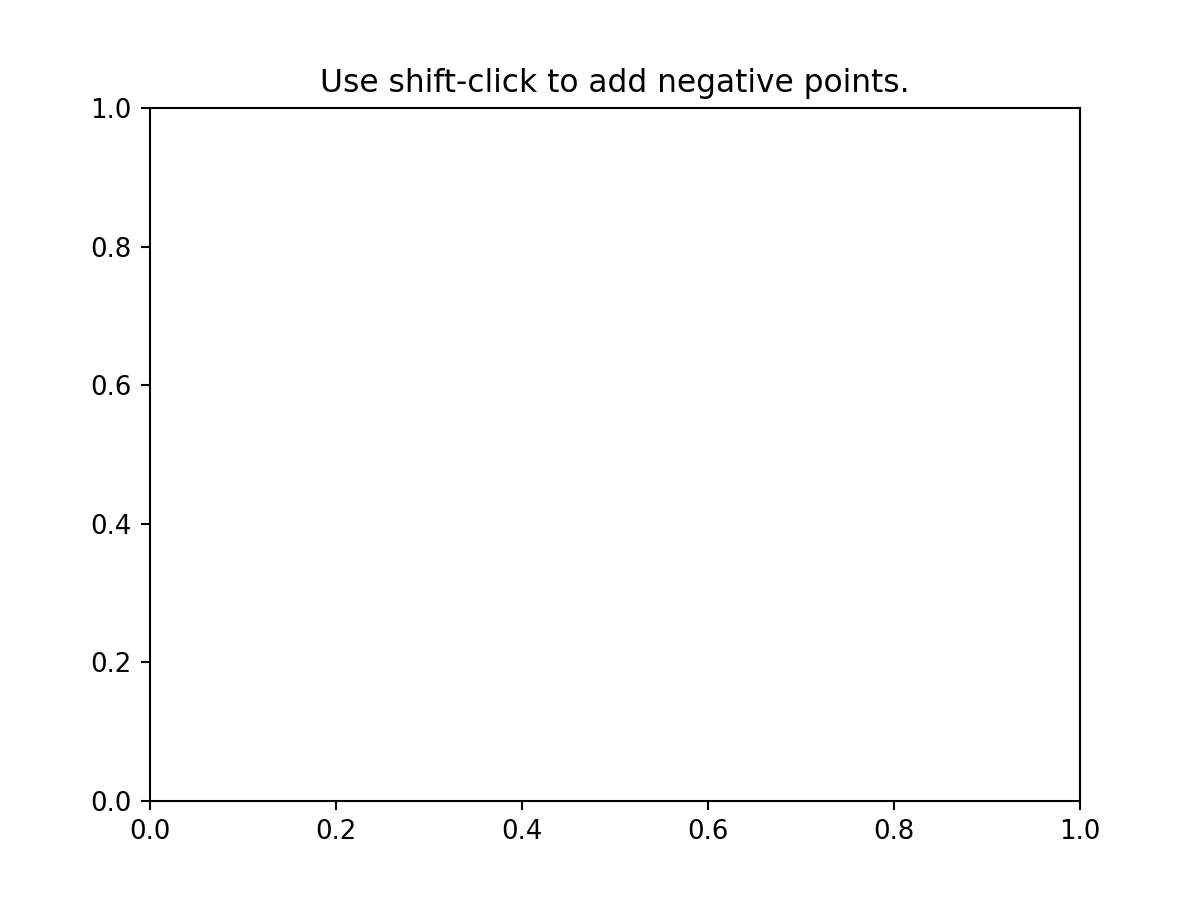

Text(0.5, 1.0, 'Use shift-click to add negative points.')

In [14]:
xTraining= np.array([[5,6]])
labels = [1]

fig = plt.figure()
plt.xlim(0,1)
plt.ylim(0,1)
cid = fig.canvas.mpl_connect('button_press_event', onclick_cart)
plt.title('Use shift-click to add negative points.')

<h2>Random Forests</h2>
<p>CART trees are known to be high variance classifiers
(if trained to full depth).
An effective way to prevent overfitting is to use <b>Bagging</b>.
Implement the function <code>forest</code>,
which builds a forest of regression trees.
Each tree should be built using training data
drawn by randomly sampling $n$ examples
from the training data with replacement.
Do not randomly sample features.
The function should output a list of trees.</p>

In [15]:
#export


def forest(xTr, yTr, m, maxdepth=np.inf):
    """Creates a random forest.
    
    Input:
        xTr:      n x d matrix of data points
        yTr:      n-dimensional vector of labels
        m:        number of trees in the forest
        maxdepth: maximum depth of tree
        
    Output:
        trees: list of TreeNode decision trees of length m
    """
    
    n, d = xTr.shape
    trees = []
    
    for _ in range(m):
        idx = np.random.choice(n, n)
        x = xTr[idx]
        y = yTr[idx]
        node = cart(x, y, maxdepth)
        trees.append(node)
    
    return trees


In [16]:
#export 


def eval_forest(trees, X, alphas=None):
    """Evaluates X using trees.
    
    Input:
        trees:  list of TreeNode decision trees of length m
        X:      n x d matrix of data points
        alphas: m-dimensional weight vector
        
    Output:
        pred: n-dimensional vector of predictions
    """
    m = len(trees)
    n,d = X.shape
    if alphas is None:
        alphas = np.ones(m) / len(trees)            
    pred = np.zeros(n)
    
    cont = []
    for tree in trees:
        cont.append(eval_tree(tree, X))
    pred = alphas.dot(cont)
    
    return pred

<IPython.core.display.Javascript object>


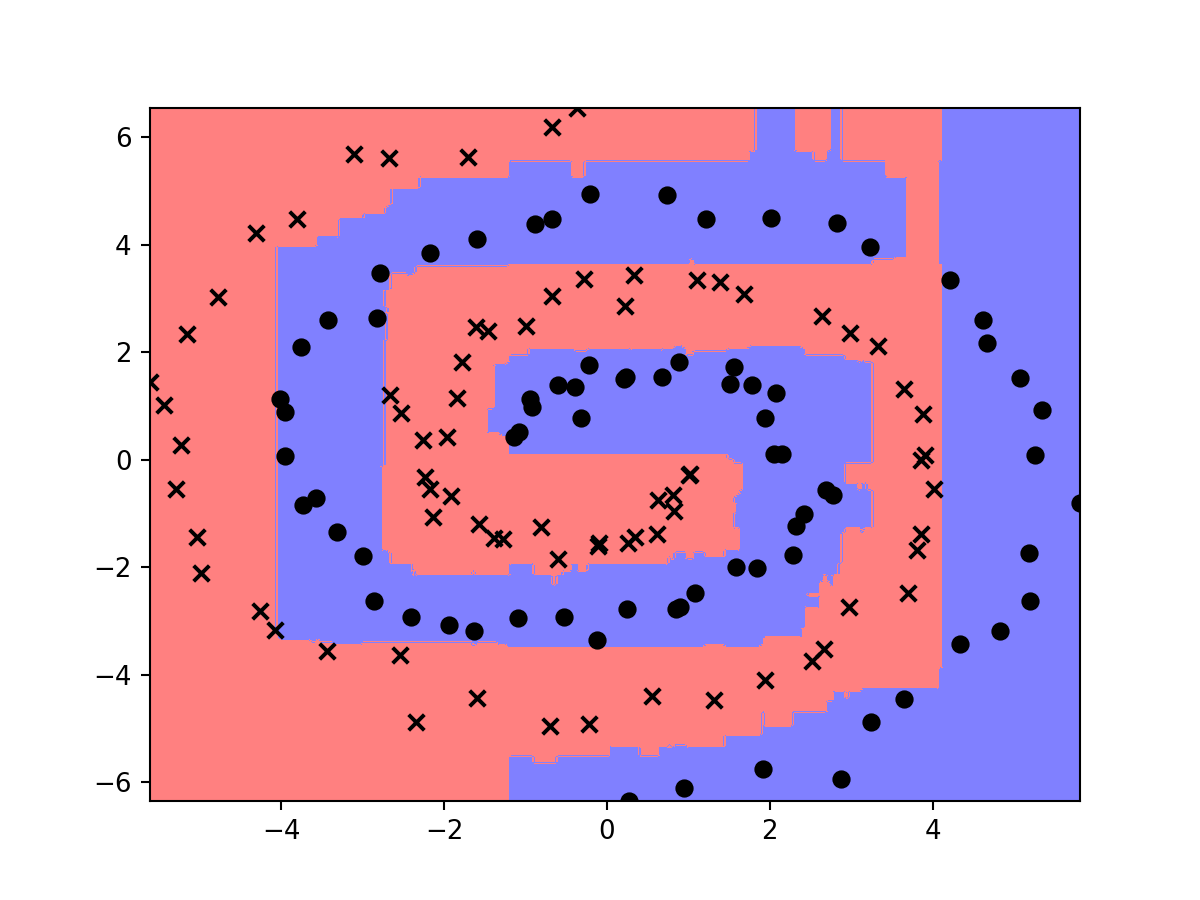

Training error: 0.0000
Testing error:  0.0400


In [17]:
#hide

trees=forest(xTrSpiral,yTrSpiral,30) # compute tree on training data 
visclassifier(lambda X:eval_forest(trees,X),xTrSpiral,yTrSpiral)


print("Training error: %.4f" % np.mean(np.sign(eval_forest(trees,xTrSpiral)) != yTrSpiral))
print("Testing error:  %.4f" % np.mean(np.sign(eval_forest(trees,xTeSpiral)) != yTeSpiral))

[0]training err = 0.0463	testing err = 0.2286
[1]training err = 0.0569	testing err = 0.1857
[2]training err = 0.0249	testing err = 0.1429
[3]training err = 0.0320	testing err = 0.1429
[4]training err = 0.0178	testing err = 0.1143
[5]training err = 0.0249	testing err = 0.1429
[6]training err = 0.0036	testing err = 0.1286
[7]training err = 0.0142	testing err = 0.1286
[8]training err = 0.0071	testing err = 0.1286
[9]training err = 0.0071	testing err = 0.1286
[10]training err = 0.0036	testing err = 0.1143
[11]training err = 0.0036	testing err = 0.1143
[12]training err = 0.0000	testing err = 0.1143
[13]training err = 0.0036	testing err = 0.1286
[14]training err = 0.0000	testing err = 0.1143
[15]training err = 0.0000	testing err = 0.1143
[16]training err = 0.0000	testing err = 0.1000
[17]training err = 0.0000	testing err = 0.1000
[18]training err = 0.0000	testing err = 0.1000
[19]training err = 0.0000	testing err = 0.1000


<IPython.core.display.Javascript object>


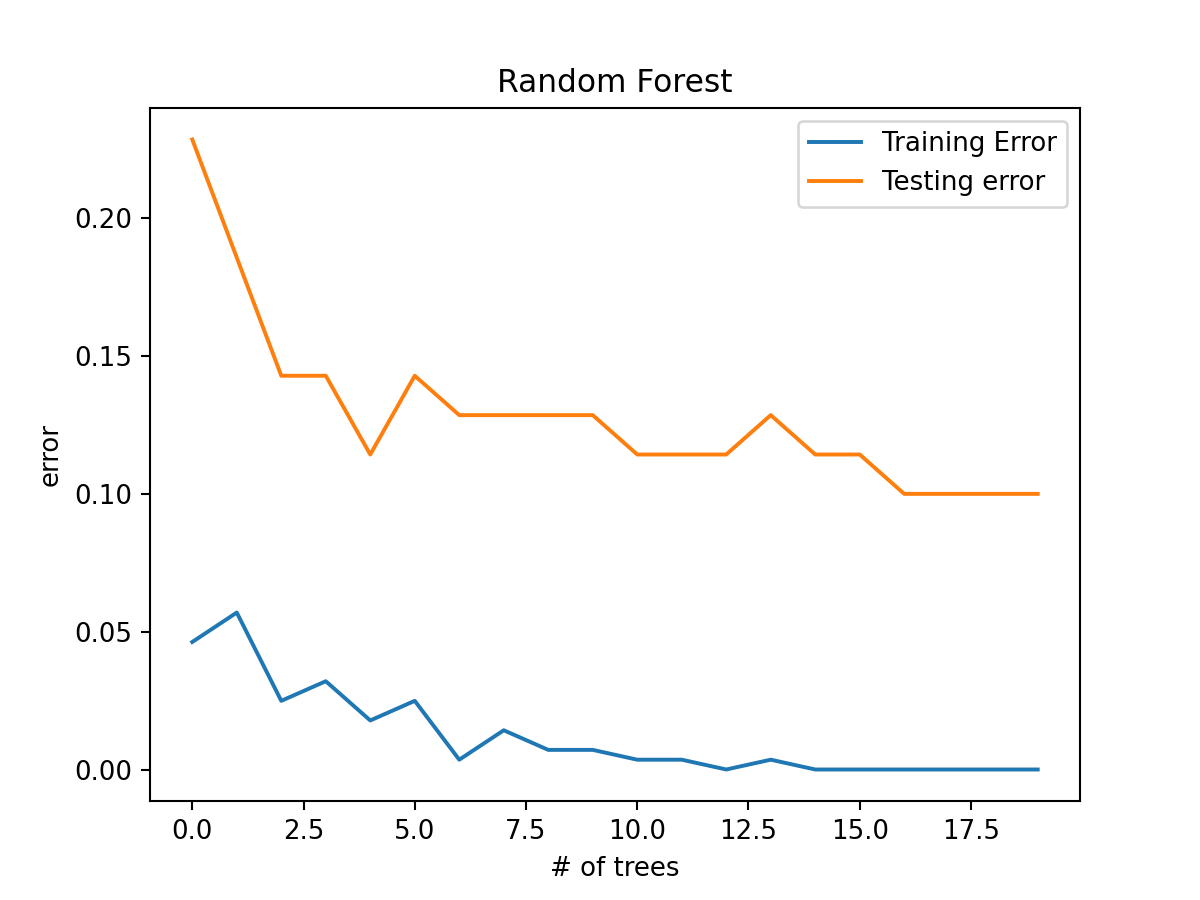

In [18]:
#hide

M=20 # max number of trees
err_trB=[]
err_teB=[]
alltrees=forest(xTrIon,yTrIon,M)
for i in range(M):
    trees=alltrees[:i+1]
    trErr = np.mean(np.sign(eval_forest(trees,xTrIon)) != yTrIon)
    teErr = np.mean(np.sign(eval_forest(trees,xTeIon)) != yTeIon)
    err_trB.append(trErr)
    err_teB.append(teErr)
    print("[%d]training err = %.4f\ttesting err = %.4f" % (i,trErr, teErr))

plt.figure()
line_tr, = plt.plot(range(M),err_trB,label="Training Error")
line_te, = plt.plot(range(M),err_teB,label="Testing error")
plt.title("Random Forest")
plt.legend(handles=[line_tr, line_te])
plt.xlabel("# of trees")
plt.ylabel("error")
plt.show()

In [19]:
#hide

def onclick_forest(event):
    """
    Visualize forest, including new point
    """
    global xTrain,yTrain,w,b,M
    # create position vector for new point
    pos=np.array([[event.xdata,event.ydata]]) 
    if event.key == 'shift': # add positive point
        color='or'
        label=1
    else: # add negative point
        color='ob'
        label=-1    
    xTrain = np.concatenate((xTrain,pos), axis = 0)
    yTrain = np.append(yTrain, label)
    marker_symbols = ['o', 'x']
    classvals = np.unique(yTrain)
        
    w = np.array(w).flatten()
    
    mycolors = [[0.5, 0.5, 1], [1, 0.5, 0.5]]
    
    # return 300 evenly spaced numbers over this interval
    res=300
    xrange = np.linspace(0, 1,res)
    yrange = np.linspace(0, 1,res)
    
    # repeat this matrix 300 times for both axes
    pixelX = repmat(xrange, res, 1)
    pixelY = repmat(yrange, res, 1).T

    xTe = np.array([pixelX.flatten(), pixelY.flatten()]).T

    # get forest
    trees=forest(xTrain,yTrain,M)
    fun = lambda X:eval_forest(trees,X)
    # test all of these points on the grid
    testpreds = fun(xTe)
    
    # reshape it back together to make our grid
    Z = testpreds.reshape(res, res)
    # Z[0,0] = 1 # optional: scale the colors correctly
    
    plt.cla()    
    plt.xlim((0,1))
    plt.ylim((0,1))
    # fill in the contours for these predictions
    plt.contourf(pixelX, pixelY, np.sign(Z), colors=mycolors)
    
    for idx, c in enumerate(classvals):
        plt.scatter(xTrain[yTrain == c,0],
            xTrain[yTrain == c,1],
            marker=marker_symbols[idx],
            color='k'
            )
    plt.show()

<IPython.core.display.Javascript object>


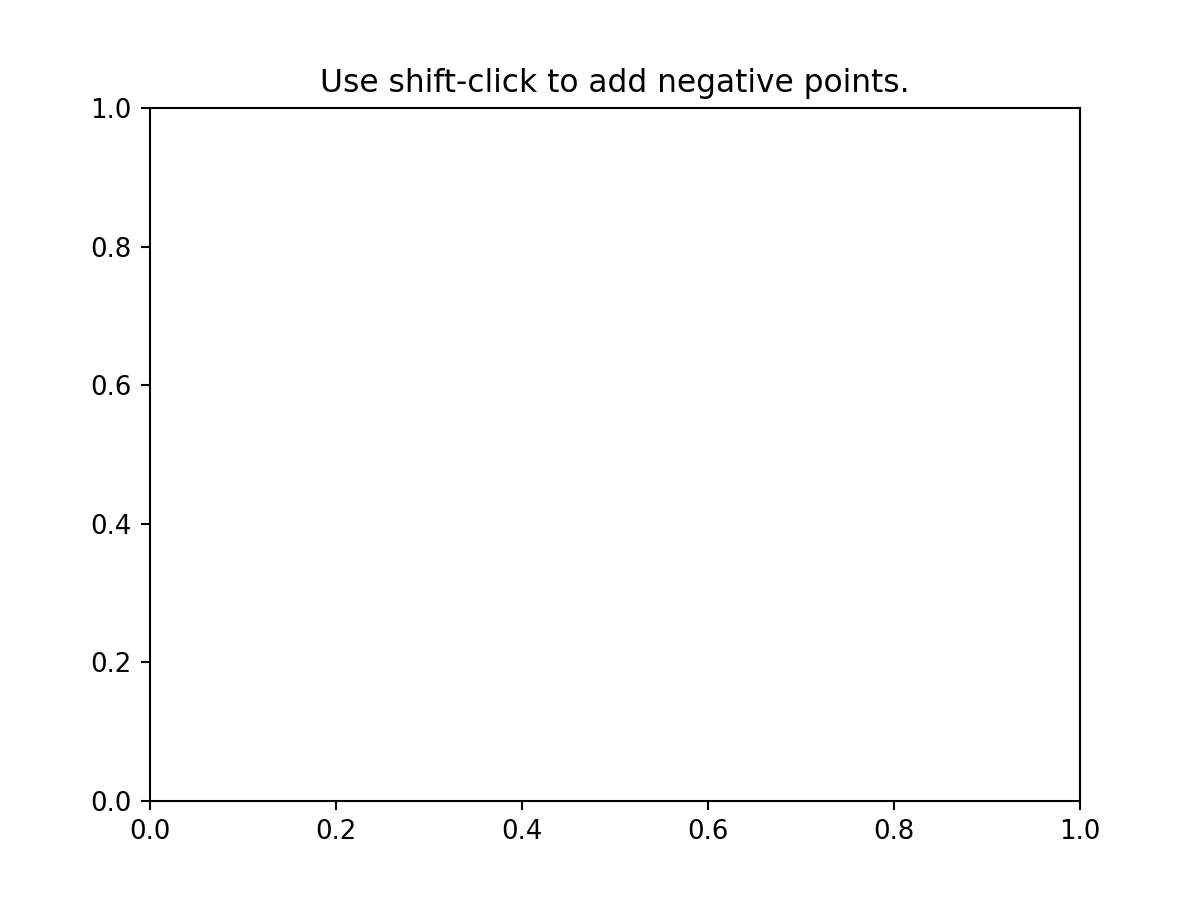

Note: there is strong delay between points


Text(0.5, 1.0, 'Use shift-click to add negative points.')

In [20]:
xTrain= np.array([[5,6]])
b=yTrIon
yTrain = np.array([1])
w=xTrIon
M=20

fig = plt.figure()
plt.xlim(0,1)
plt.ylim(0,1)
cid = fig.canvas.mpl_connect('button_press_event', onclick_forest)
print('Note: there is strong delay between points')
plt.title('Use shift-click to add negative points.')

<h2>Boosting</h2>

<p>Another option to improve your decision trees is to build trees of small depth (e.g. only depth=3 or depth=4). These do not have high variance, but instead suffer from <b>high bias</b>. You can reduce the bias of a classifier with boosting. Implement the function <code>boosttree</code>, which applies Adaboost on your <code>cart</code> functions. You should be able to use the function <code>evalforest</code> to evaluate your boosted ensemble (provdided you pass on the weights correctly.)</p>

In [21]:
def boost_tree(x,y,maxiter=100, maxdepth=2):
    """Learns a boosted decision tree.
    
    Input:
        x:        n x d matrix of data points
        y:        n-dimensional vector of labels
        maxiter:  maximum number of trees
        maxdepth: maximum depth of a tree
        
    Output:
        forest: list of TreeNode decision trees of length m
        alphas: m-dimensional weight vector
        
    (note, m is at most maxiter, but may be smaller,
    as dictated by the Adaboost algorithm)
    """
    assert np.allclose(np.unique(y), np.array([-1,1])); # the labels must be -1 and 1 
    n,d = x.shape
    weights = np.ones(n) / n
    forest  = []
    alphas = []
    for _ in range(maxiter):        
        h = cart(x, y, maxdepth, weights)
        #np.sign could be return 0, thus increase error unnecessary
        pred = (eval_tree(h, x) > 0).astype(int)
        pred = pred - (1-pred)
        l = (pred != y).astype(int)
        eps = np.dot(l, weights)
        # I think eps > 0.5 should be warning
        # as we can set alpha to negative
        if eps > 0.5:
            print(f"Warning weaker learner error {eps} is greater than 0.5")
            
        alpha = 0.5 * np.log((1 - eps) / eps)
        alphas.append(alpha)
        forest.append(h)

        hxy = pred * y
        enum = np.exp(-alpha * hxy)
        denom = 2 * np.sqrt(eps * (1 - eps))
        weights = weights * enum / denom
        weights = weights / weights.sum()

    return forest, np.array(alphas)

[0]training err = 0.1139	testing err = 0.2000
[1]training err = 0.0819	testing err = 0.1714
[2]training err = 0.0463	testing err = 0.1714
[3]training err = 0.0498	testing err = 0.1714
[4]training err = 0.0320	testing err = 0.2000
[5]training err = 0.0249	testing err = 0.2286
[6]training err = 0.0249	testing err = 0.1857
[7]training err = 0.0000	testing err = 0.1143
[8]training err = 0.0071	testing err = 0.1143
[9]training err = 0.0036	testing err = 0.1429
[10]training err = 0.0000	testing err = 0.1000
[11]training err = 0.0000	testing err = 0.1000
[12]training err = 0.0000	testing err = 0.1286
[13]training err = 0.0000	testing err = 0.1000
[14]training err = 0.0000	testing err = 0.1000
[15]training err = 0.0000	testing err = 0.1000
[16]training err = 0.0000	testing err = 0.1143
[17]training err = 0.0000	testing err = 0.1286
[18]training err = 0.0000	testing err = 0.1143
[19]training err = 0.0000	testing err = 0.1143


<IPython.core.display.Javascript object>


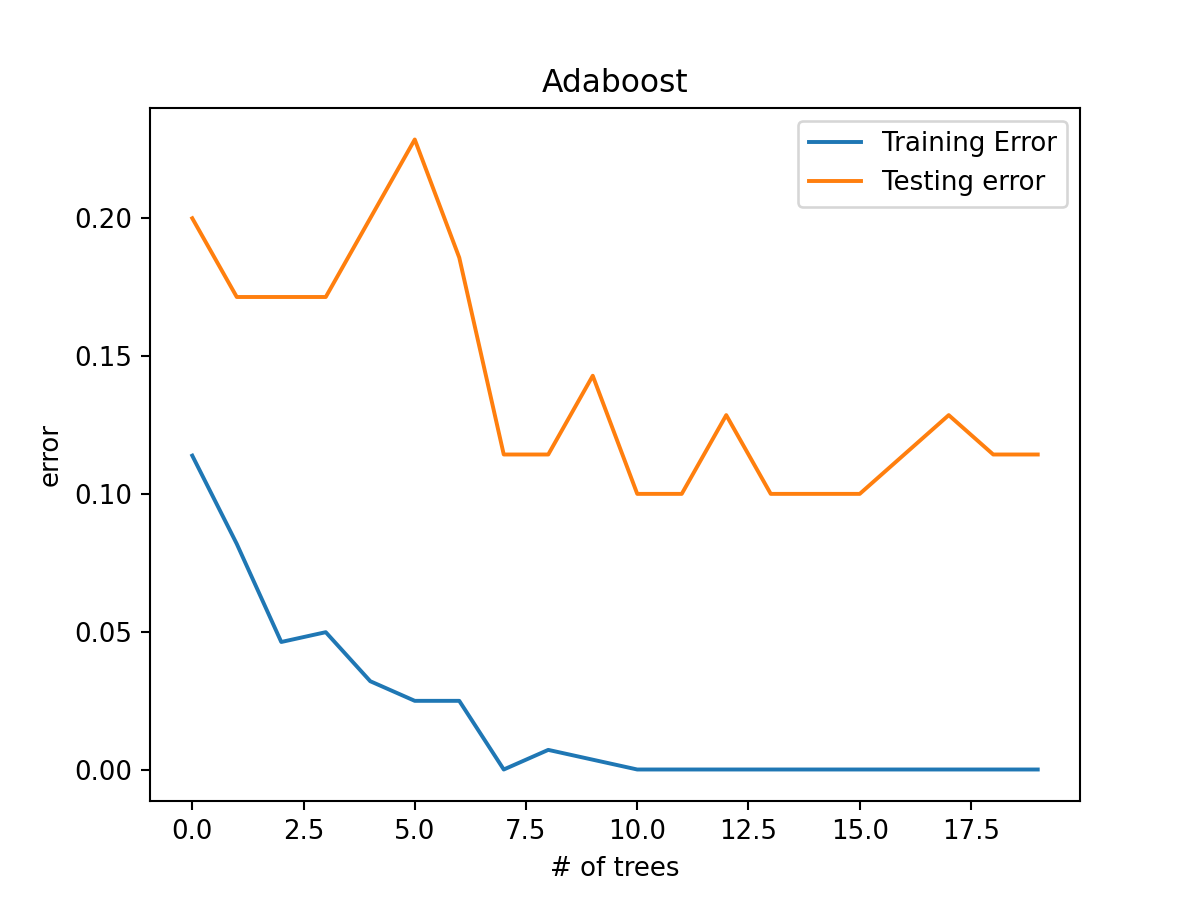

In [22]:
M=20 # max number of trees
alltrees,allalphas=boost_tree(xTrIon,yTrIon,maxdepth=3,maxiter=M)

err_trB=[]
err_teB=[]
for i in range(M):
    trees=alltrees[:i+1]
    alphas=allalphas[:i+1]
    trErr = np.mean(np.sign(eval_forest(trees,xTrIon,alphas)) != yTrIon)
    teErr = np.mean(np.sign(eval_forest(trees,xTeIon,alphas)) != yTeIon)
    err_trB.append(trErr)
    err_teB.append(teErr)
    print("[%d]training err = %.4f\ttesting err = %.4f" % (i,trErr, teErr))

plt.figure()
line_tr, = plt.plot(range(M),err_trB,label="Training Error")
line_te, = plt.plot(range(M),err_teB,label="Testing error")
plt.title("Adaboost")
plt.legend(handles=[line_tr, line_te])
plt.xlabel("# of trees")
plt.ylabel("error")
plt.show()

<IPython.core.display.Javascript object>


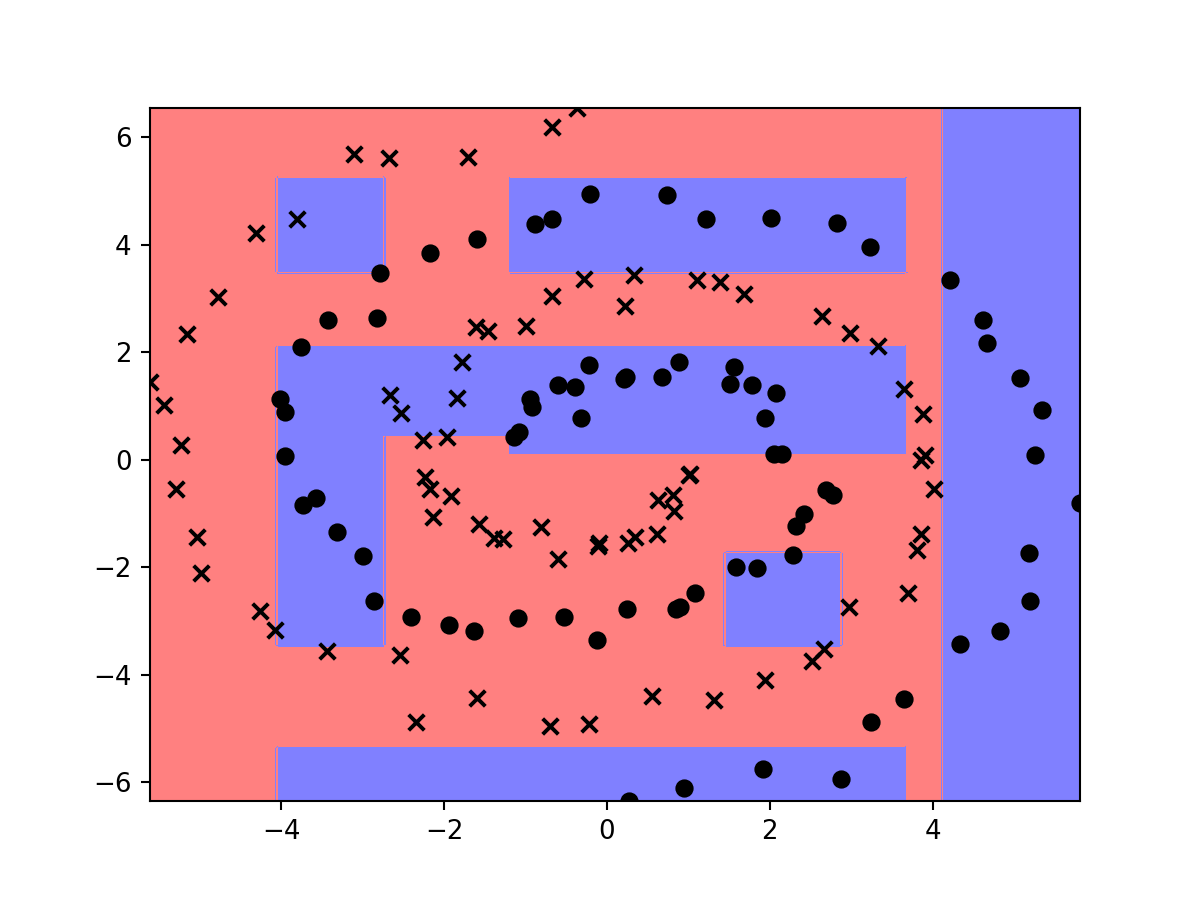

Training error: 0.1333
Testing error:  0.1733
CPU times: user 1.31 s, sys: 172 ms, total: 1.48 s
Wall time: 1.08 s


In [23]:
%%time
trees,alphas=boost_tree(xTrSpiral,yTrSpiral,maxdepth=3,maxiter=20)
visclassifier(lambda X:eval_forest(trees,X,alphas),xTrSpiral,yTrSpiral)

print("Training error: %.4f" % np.mean(np.sign(eval_forest(trees,xTrSpiral)) != yTrSpiral))
print("Testing error:  %.4f" % np.mean(np.sign(eval_forest(trees,xTeSpiral)) != yTeSpiral))